~~~
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~
<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/cxr-foundation/blob/master/notebooks/train_data_efficient_classifier.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/cxr-foundation/blob/master/notebooks/train_data_efficient_classifier.ipynb">
      <img alt="GitHub logo" src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/google/cxr-foundation">
      <img alt="HuggingFace logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on HuggingFace
    </a>
  </td>
</tr></tbody></table>


# CXR Foundation Demo

This notebook demonstrates the richness of information contained in embeddings, generated from full Chest X-Ray images. The contents include how to:

- Download precomputed embeddings and labels based on the open-access NIH ChestX-ray14 dataset
- Train a simple neural network (WITHOUT needing GPU) to detect a medical finding in the embeddings

The embeddings are the *elixr_img_contrastive* which are text-aligned image embedding from the Q-former output in ELIXR (https://arxiv.org/abs/2308.01317), can be used for image retrieval.

**NOTE:**  To streamline this Colab demonstration and eliminate the need for lengthy downloads, we've precomputed the embeddings, which are considerably smaller in size (similar to compressed images). You can learn how to generate embeddings using the other [notebooks](https://colab.research.google.com/github/google-health/cxr-foundation/blob/master/notebooks/).

# Installation

Install the CXR Foundation package

In [1]:
# Notebook specific dependencies. Show details only if installing.
!pip install matplotlib tf-models-official==2.14.0 > /dev/null 2>&1 && echo "Installation successful" || (>&2 pip install matplotlib tf-models-official==2.14.0 > /dev/null)

Installation successful


**IMPORTANT**: If you are using Colab, you must restart the runtime after installing new packages.

NOTE: There will be some ERROR messages due to the protobuf library - this is normal.

# Authenticate to Access Data

In [2]:
# @title Authenticate with HuggingFace, skip if you have a HF_TOKEN secret

# Authenticate user for HuggingFace if needed. Enter token below if requested.
from huggingface_hub.utils import HfFolder

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()
else:
    print("Token already set")

Token already set


# Download Data

The NIH ChestX-ray14 dataset, consists of over 100,000 de-identified images of chest x-rays, with fourteen common disease labels, text-mined from the text radiological reports via NLP techniques. The dataset is available on the NIH [download site](https://nihcc.app.box.com/v/ChestXray-NIHCC) and on [Google Cloud](https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest).

In [3]:
# @title Download labels from HuggingFace

import io
import os
import pandas as pd

INPUT_DIR = '/content/data/input'

# Make a directory to download the data
os.makedirs('data/input', exist_ok=True)

from huggingface_hub import hf_hub_download
HF_REPO_ID = "google/cxr-foundation"

# Download and inspect the labels file.
# There is a column for each of several findings, which indicate whether or not
# the condition is present in the image file.
LABEL_FILE_PATH = hf_hub_download(repo_id=HF_REPO_ID, filename='labels.csv', subfolder='precomputed_embeddings', local_dir=INPUT_DIR)

# Download image thumbnails.
THUMBNAILS_FILE_PATH = hf_hub_download(repo_id=HF_REPO_ID, filename='thumbnails_id_to_webp.npz', subfolder='precomputed_embeddings', local_dir=INPUT_DIR)

# Download precomupted embedding.
EMBEDDINGS_NPZ_FILE_PATH = hf_hub_download(repo_id=HF_REPO_ID, filename='embeddings.npz', subfolder='precomputed_embeddings', local_dir=INPUT_DIR)


full_labels_df = pd.read_csv(LABEL_FILE_PATH)
display(full_labels_df.head())

,image_id,patient_id,case_id,split,AIRSPACE_OPACITY,FRACTURE,PNEUMOTHORAX,CONSOLIDATION,EFFUSION,PULMONARY_EDEMA,ATELECTASIS,CARDIOMEGALY,dicom_file
0,00015845_007,15845,7,train,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00015845_007.dcm
1,00008774_005,8774,5,train,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,00008774_005.dcm
2,00022600_001,22600,1,train,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00022600_001.dcm
3,00017324_012,17324,12,train,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00017324_012.dcm
4,00021311_000,21311,0,train,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,00021311_000.dcm


In [4]:
# @title Select below the diagnosis and number of cases to use per label:

DIAGNOSIS = "FRACTURE" # @param ["AIRSPACE_OPACITY", "FRACTURE", "PNEUMOTHORAX", "CONSOLIDATION", "EFFUSION", "PULMONARY_EDEMA", "ATELECTASIS", "CARDIOMEGALY"]
MAX_CASES_PER_CATEGORY = 400 # @param {type:"slider", min:50, max:400, step:5}

# Labels df of relevant files
df_labels = pd.concat((full_labels_df[full_labels_df[DIAGNOSIS]==0][:MAX_CASES_PER_CATEGORY],
                      full_labels_df[full_labels_df[DIAGNOSIS]==1][:MAX_CASES_PER_CATEGORY]), ignore_index=True)

print(f"Selected {MAX_CASES_PER_CATEGORY} positive and {MAX_CASES_PER_CATEGORY} negative cases")
df_labels[["image_id", DIAGNOSIS, "dicom_file"]]

Selected 400 positive and 400 negative cases


,image_id,FRACTURE,dicom_file
0,00015845_007,0.0,00015845_007.dcm
1,00008774_005,0.0,00008774_005.dcm
2,00022600_001,0.0,00022600_001.dcm
3,00017324_012,0.0,00017324_012.dcm
4,00021311_000,0.0,00021311_000.dcm
...,...,...,...
787,00010477_001,1.0,00010477_001.dcm
788,00012424_001,1.0,00012424_001.dcm
789,00029514_005,1.0,00029514_005.dcm
790,00025608_001,1.0,00025608_001.dcm


# Util functions and imports

# Fetch Embeddings

## Storage Format

The embeddings are stored as a .npz file, with the keys representing the image_id (e.g., 00018329_008). The NPZ file format is used to store NumPy arrays in a compressed form, providing an efficient way to manage large datasets containing multiple arrays.

In [5]:
# @title Parse Precomputed Embeddings
import numpy as np

embeddings_file = np.load(EMBEDDINGS_NPZ_FILE_PATH)
df_labels['embeddings'] = df_labels['image_id'].apply(lambda x: embeddings_file[x])
embeddings_file.close()

display(df_labels[['image_id', 'embeddings']])

,image_id,embeddings
0,00015845_007,"[-0.17128147, 0.008595931, -0.0005963545, 0.06..."
1,00008774_005,"[-0.19136983, -0.06103782, -0.027953472, 0.070..."
2,00022600_001,"[-0.14782454, -0.030647462, -0.13165669, 0.003..."
3,00017324_012,"[-0.104966134, 0.021651793, -0.14169557, -0.00..."
4,00021311_000,"[-0.113549404, 0.03401351, -0.2252285, 0.20830..."
...,...,...
787,00010477_001,"[-0.12844677, -0.09330263, -0.21856011, 0.0701..."
788,00012424_001,"[-0.17991081, -0.026302714, -0.1602918, 0.1465..."
789,00029514_005,"[-0.09570231, 0.04422743, -0.14054316, 0.01346..."
790,00025608_001,"[-0.12378115, -0.057432014, -0.14288124, 0.084..."


## Prepare Data for Model Training

In [6]:
# @title Separate into training, validation, and testing sets.

from sklearn.model_selection import train_test_split

TEST_SPLIT = 0.1 # @param {type:"slider", min:0.05, max:0.8, step:0.05}

df_train, df_validate = train_test_split(df_labels, test_size=TEST_SPLIT)

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_validate)}")

Training set size: 712
Validation set size: 80


## Train a Model

Finally, we can train a model using the embeddings! With a simple feed-forward neural network, it should take < 5 minutes to train 100 epochs! No GPU required.

In [7]:
# @title Create Tensorflow Dataset & Model functions
import tensorflow as tf
import tensorflow_models as tfm
import numpy as np
from typing import Dict, Iterable
from official.modeling.optimization import lars


def create_tf_dataset_from_embeddings(
    embeddings: Iterable[np.ndarray],
    labels: Iterable[int],
    embeddings_size: int
) -> tf.data.Dataset:
    """Create a tf.data.Dataset from embeddings, image IDs, and labels."""
    # Ensure embeddings, image_ids, and labels are lists
    embeddings = list(embeddings)
    labels = list(labels)

    # Check that the lengths match
    assert len(embeddings) == len(labels), \
        "Lengths of embeddings, and labels must be equal"

    # Convert embeddings to np.float32 if necessary
    embeddings = [np.asarray(e, dtype=np.float32) for e in embeddings]

    # Create datasets for embeddings and labels
    ds_embeddings = tf.data.Dataset.from_tensor_slices(embeddings)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels)

    # Zip embeddings and labels into a single dataset
    dataset = tf.data.Dataset.zip((ds_embeddings, ds_labels))

    return dataset


def create_model(heads,
                 token_num,
                 embeddings_size,
                 learning_rate=0.1,
                 end_lr_factor=1.0,
                 dropout=0.0,
                 decay_steps=1000,
                 loss_weights=None,
                 hidden_layer_sizes=[512, 256],
                 weight_decay=0.0,
                 seed=None) -> tf.keras.Model:
  """
  Creates linear probe or multilayer perceptron using LARS + cosine decay.
  """
  inputs = tf.keras.Input(shape=(token_num * embeddings_size,))
  inputs_reshape = tf.keras.layers.Reshape((token_num, embeddings_size))(inputs)
  inputs_pooled = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(inputs_reshape)
  hidden = inputs_pooled
  # If no hidden_layer_sizes are provided, model will be a linear probe.
  for size in hidden_layer_sizes:
    hidden = tf.keras.layers.Dense(
        size,
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
        kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
        bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay))(
            hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout, seed=seed)(hidden)
  output = tf.keras.layers.Dense(
      units=len(heads),
      activation='sigmoid',
      kernel_initializer=tf.keras.initializers.HeUniform(seed=seed))(
          hidden)

  outputs = {}
  for i, head in enumerate(heads):
    outputs[head] = tf.keras.layers.Lambda(
        lambda x: x[..., i:i + 1], name=head.lower())(
            output)

  model = tf.keras.Model(inputs, outputs)
  learning_rate_fn = tf.keras.experimental.CosineDecay(
      tf.cast(learning_rate, tf.float32),
      tf.cast(decay_steps, tf.float32),
      alpha=tf.cast(end_lr_factor, tf.float32))
  model.compile(
      optimizer=tfm.optimization.lars.LARS(
          learning_rate=learning_rate_fn),
      loss=dict([(head, 'binary_crossentropy') for head in heads]),
      loss_weights=loss_weights or dict([(head, 1.) for head in heads]),
      weighted_metrics=[
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.AUC(curve='PR', name='auc_pr')])
  return model

In [ ]:
# @title Prepare datasets & run training a TensorFlow model for diagnosis prediction

# Constants defining the number of tokens and the size of each embedding vector
TOKEN_NUM = 32
EMBEDDINGS_SIZE = 128

# Prepare the training and validation datasets using embeddings and diagnosis labels
training_data = create_tf_dataset_from_embeddings(
    embeddings=df_train["embeddings"].values,
    labels=df_train[DIAGNOSIS].values,
    embeddings_size=TOKEN_NUM * EMBEDDINGS_SIZE)

validation_data = create_tf_dataset_from_embeddings(
    embeddings=df_validate["embeddings"].values,
    labels=df_validate[DIAGNOSIS].values,
    embeddings_size=TOKEN_NUM * EMBEDDINGS_SIZE)

# Create the model with the specified configuration
model = create_model(
    [DIAGNOSIS],
    token_num=TOKEN_NUM,
    embeddings_size = EMBEDDINGS_SIZE,
)

# Train the model using the prepared datasets, with specific batch sizes and caching strategies
model.fit(
    x=training_data.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data.batch(1).cache(),
    epochs=100,
)

# Display the model architecture summary
model.summary()

## Examine metrics

In [9]:
# @title Organize the output and display a sample of the predictions

rows = []

for embeddings, label in validation_data.batch(1):
  row = {
      f'{DIAGNOSIS}_prediction': model(embeddings)[DIAGNOSIS].numpy().flatten()[0],
      f'{DIAGNOSIS}_value': label.numpy().flatten()[0]
  }
  rows.append(row)

eval_df = pd.DataFrame(rows)
eval_df.head()

,FRACTURE_prediction,FRACTURE_value
0,0.783341,0.0
1,0.599864,0.0
2,0.661488,0.0
3,0.772688,1.0
4,0.689369,0.0


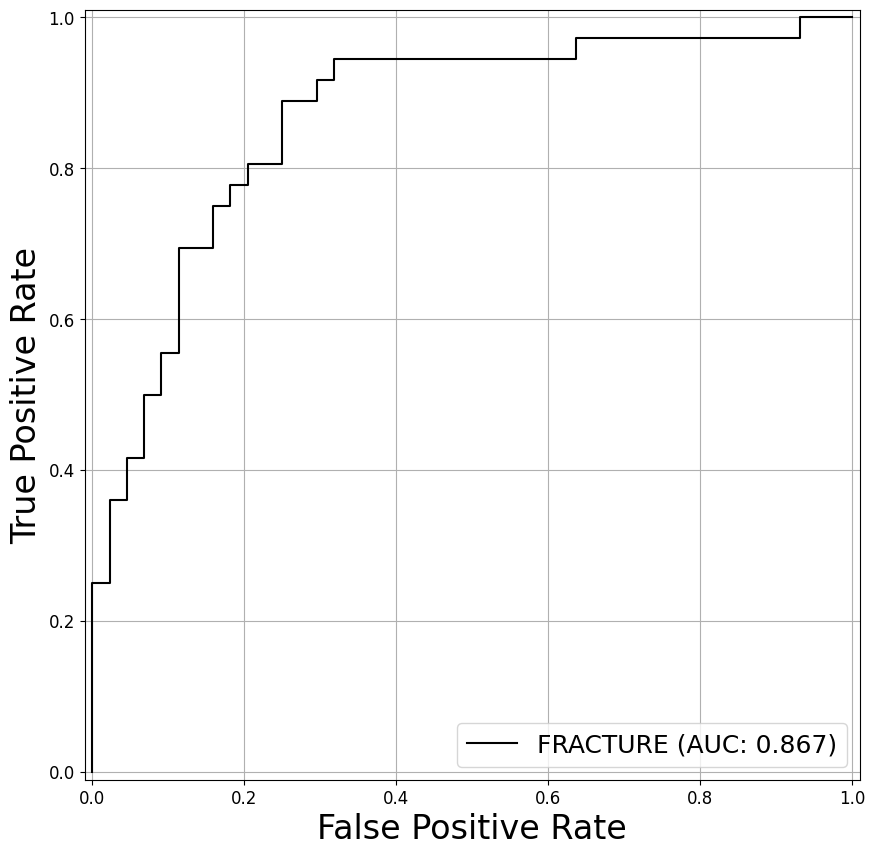

In [10]:
import sklearn
import matplotlib.pyplot as plt

def plot_curve(x, y, auc, x_label=None, y_label=None, label=None):
  fig = plt.figure(figsize=(10, 10))
  plt.plot(x, y, label=f'{label} (AUC: %.3f)' % auc, color='black')
  plt.legend(loc='lower right', fontsize=18)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  if x_label:
    plt.xlabel(x_label, fontsize=24)
  if y_label:
    plt.ylabel(y_label, fontsize=24)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(visible=True)

%matplotlib inline
labels = eval_df[f'{DIAGNOSIS}_value'].values
predictions = eval_df[f'{DIAGNOSIS}_prediction'].values
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(
    labels,
    predictions,
    drop_intermediate=False)
auc = sklearn.metrics.roc_auc_score(labels, predictions)
plot_curve(false_positive_rate, true_positive_rate, auc, x_label='False Positive Rate', y_label='True Positive Rate', label=DIAGNOSIS)

<IPython.core.display.Javascript object>

Display images from the validation set, categorized by the model's prediction score compared to the actual ground truth label. Include up to three images for each category.


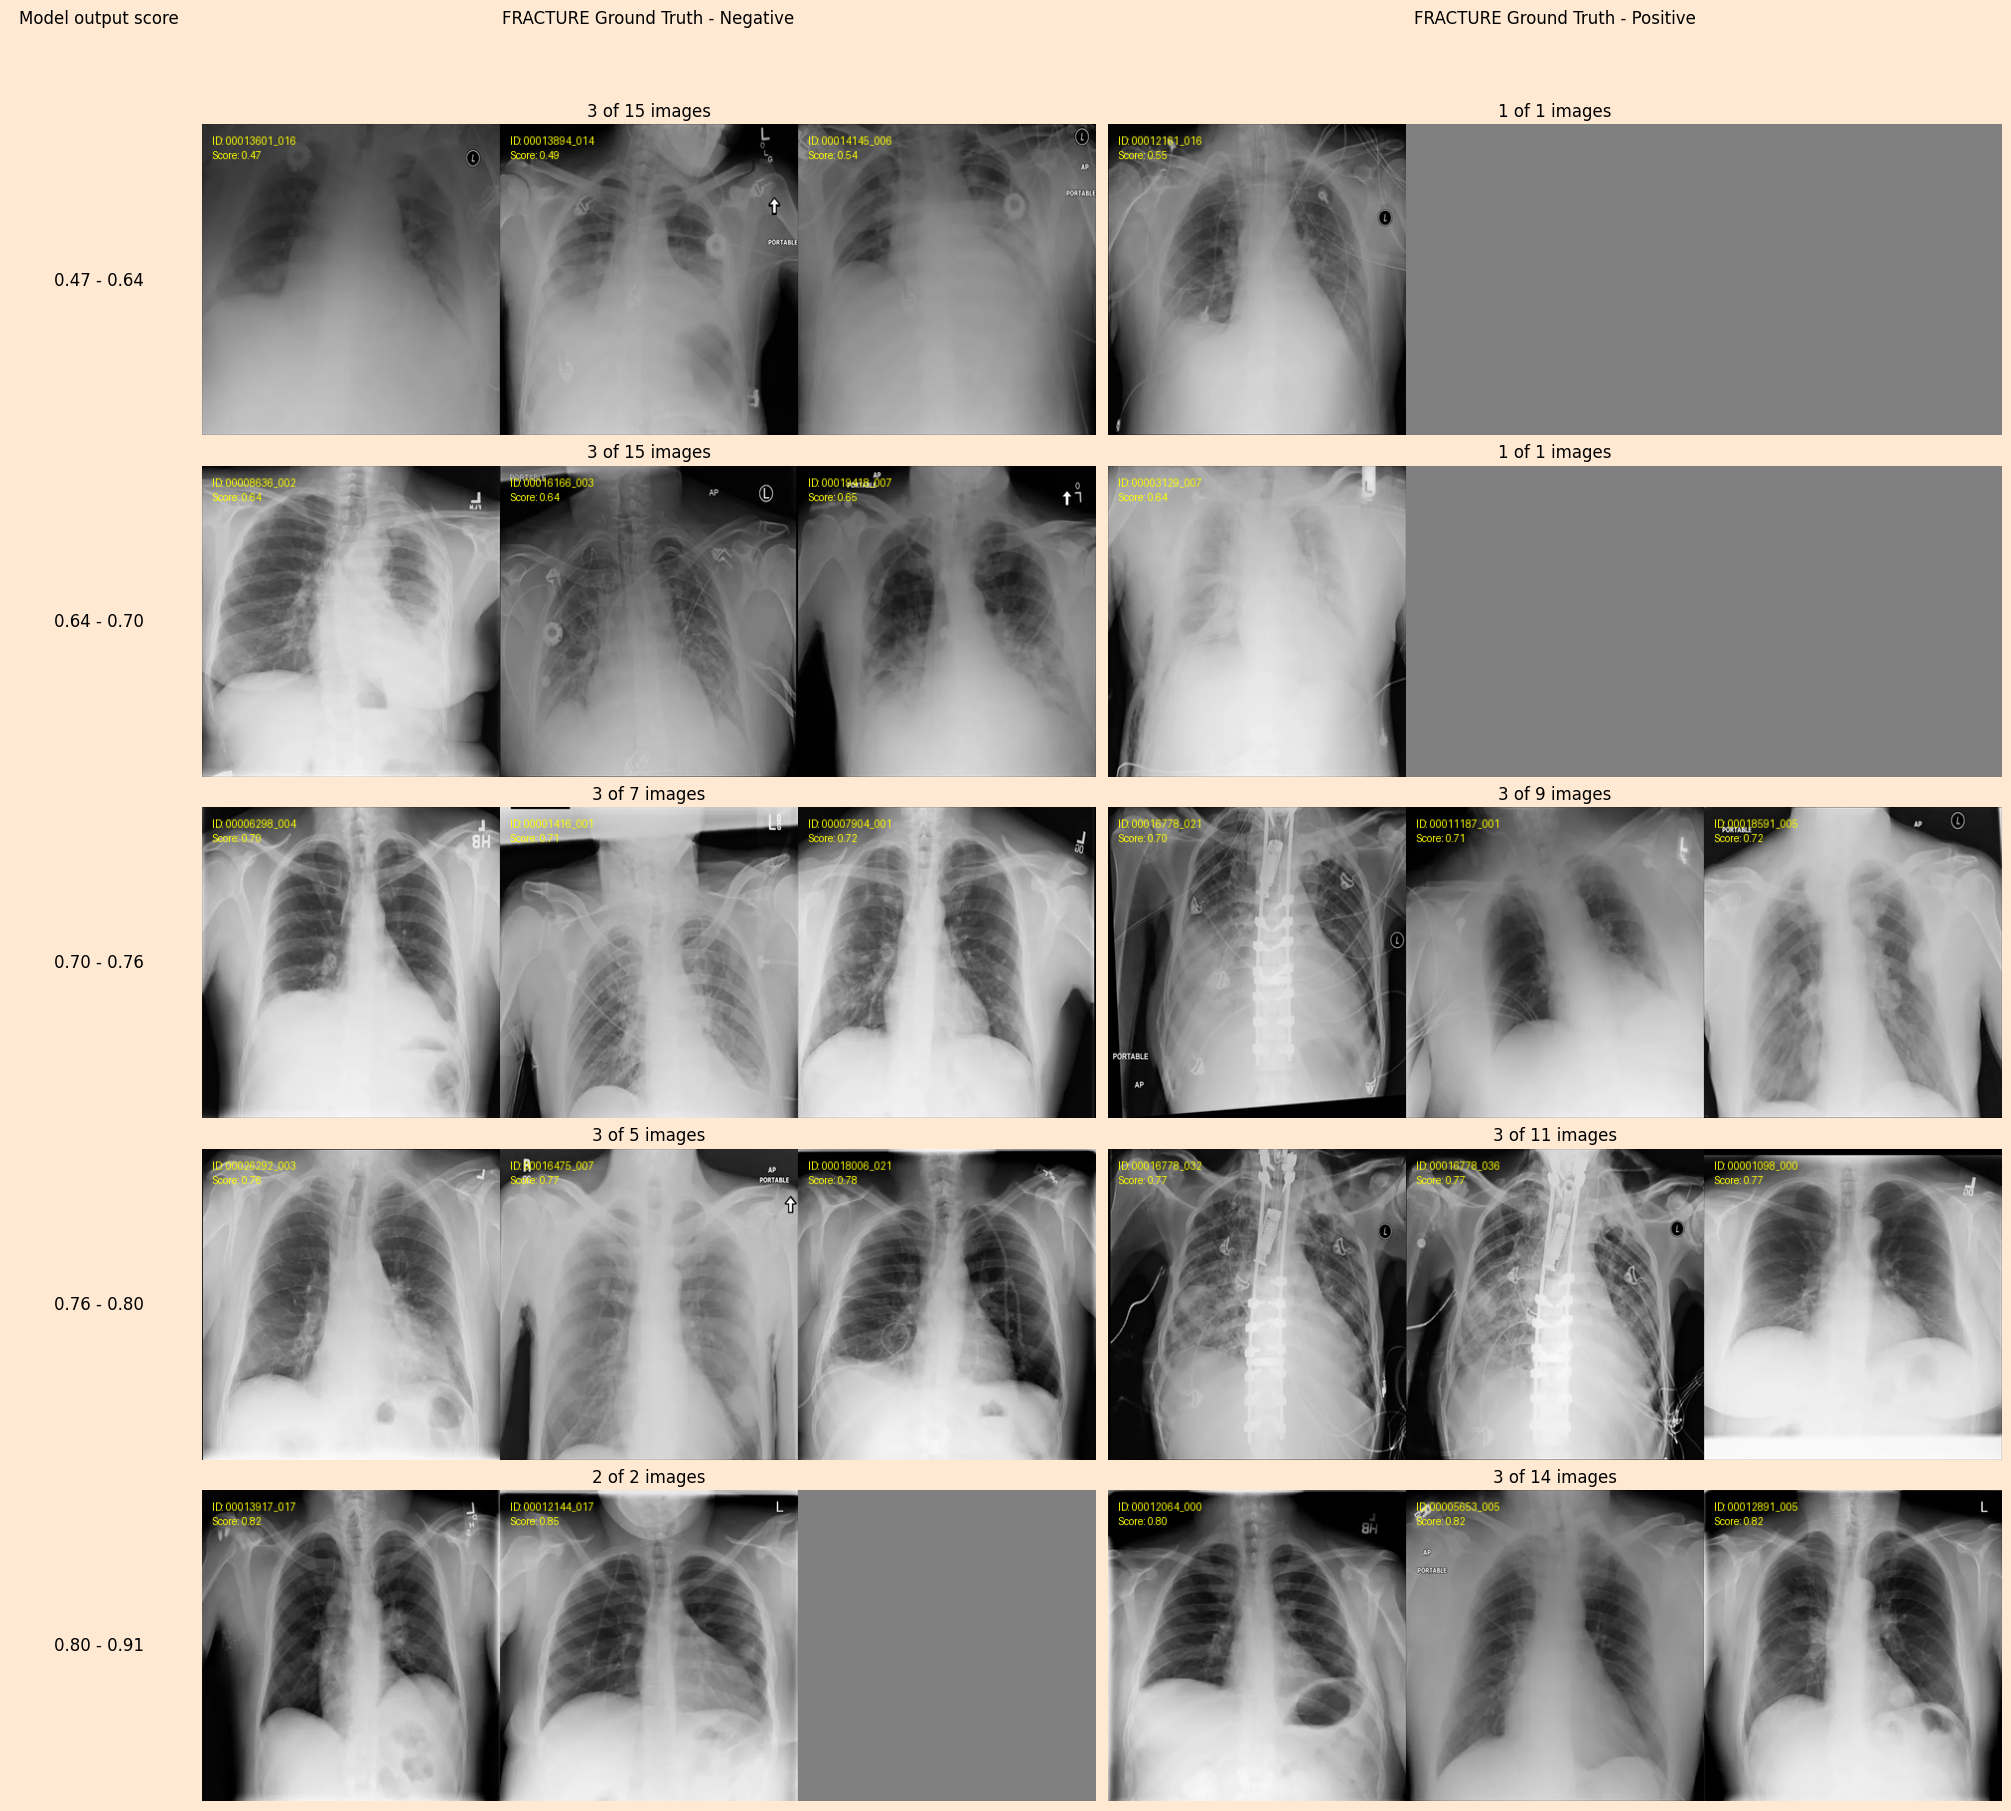

In [11]:
# @title Show Sample Images (prediction scores vs label)

import numpy as np
from PIL import Image, ImageOps, ImageDraw
import matplotlib.pyplot as plt
from matplotlib import gridspec
import io
import pandas as pd
from google.colab import output

NUM_BUCKETS=5

thumbnails = np.load(THUMBNAILS_FILE_PATH, allow_pickle=True)

output.no_vertical_scroll()

sorted_indices = np.argsort(predictions)
sorted_predictions = predictions[sorted_indices]
sorted_labels = labels[sorted_indices]
sorted_image_id = df_validate["image_id"].values[sorted_indices]
sorted_image_id, sorted_labels, sorted_predictions


def define_buckets(predictions, num_buckets):
    quantiles = pd.Series(predictions).quantile([i / num_buckets for i in range(num_buckets + 1)]).tolist()
    # Make sure the range covers the last value inclusively
    quantiles[-1] = quantiles[-1] + 0.01
    return [(quantiles[i], quantiles[i + 1]) for i in range(len(quantiles) - 1)]

def bucket_images(sorted_predictions, sorted_labels, num_buckets=4):
    # Define buckets
    buckets = define_buckets(sorted_predictions, num_buckets)
    bucketed_images = {bucket: {0: [], 1: []} for bucket in buckets}

    # Loop over all predictions, labels, and images to organize them into the buckets
    for index, (score, label) in enumerate(zip(sorted_predictions, sorted_labels)):
        for bucket in buckets:
            if bucket[0] <= score < bucket[1]:
                bucketed_images[bucket][label].append(index)  # Store the index instead of the image
                break
    return bucketed_images


def plot_bucketed_images(bucketed_images, sorted_predictions, sorted_image_id, thumbnails):
    num_columns = 2  # (2 for Label 0 and Label 1)
    num_rows = len(bucketed_images)

    desired_height = 300  # height in pixels for each image
    desired_width = 300   # width in pixels for each image

    # Create the figure with specified size, considering the new image dimensions
    fig = plt.figure(figsize=(20, (num_rows + 1) * (desired_height / 100)), constrained_layout=True)
    gs = gridspec.GridSpec(nrows=num_rows + 1, ncols=num_columns + 1, figure=fig,
                           width_ratios=[1, 5, 5], height_ratios=[1] + [5] * num_rows)
    fig.patch.set_facecolor('#ffe9d2')

    # Initialize the axes array using the GridSpec
    axes = np.empty((num_rows + 1, num_columns + 1), dtype=object)
    for i in range(num_rows + 1):
        for j in range(num_columns + 1):
            axes[i, j] = plt.subplot(gs[i, j])
            for spine in axes[i, j].spines.values():
                spine.set_visible(True)
                spine.set_linewidth(2)
                spine.set_edgecolor('black')

    # Setting title rows and column labels
    axes[0, 1].set_title(f"{DIAGNOSIS} Ground Truth - Negative")
    axes[0, 1].axis('off')
    axes[0, 2].set_title(f"{DIAGNOSIS} Ground Truth - Positive")
    axes[0, 2].axis('off')
    axes[0, 0].set_title("Model output score")
    axes[0, 0].axis('off')

    for i, bucket in enumerate(bucketed_images.keys()):
        axes[i + 1, 0].text(0.5, 0.5, f"{bucket[0]:.2f} - {bucket[1]:.2f}",
                            rotation=0, size='large', ha='center', va='center')
        axes[i + 1, 0].axis('off')

    # Plot images in their respective cell, limited to 3 images max
    for i, (bucket, images_dict) in enumerate(bucketed_images.items()):
        for j, label in enumerate(sorted(images_dict.keys())):
            ax = axes[i + 1, j + 1]
            ax.axis('off')
            img_count = len(images_dict[label])
            indices = images_dict[label][:3]  # Limit to the first 3 indices
            combined_image = Image.new('RGB', (desired_width * 3, desired_height), 'grey')
            x_offset = 0
            for idx in indices:
                img = Image.open(io.BytesIO(thumbnails[sorted_image_id[idx]].tobytes()))
                img_resized = img.resize((desired_width, desired_height), Image.Resampling.LANCZOS)
                combined_image.paste(img_resized, (x_offset, 0))
                draw = ImageDraw.Draw(combined_image)
                text = f"ID: {sorted_image_id[idx]}\nScore: {sorted_predictions[idx]:.2f}"
                draw.text((x_offset + 10, 10), text, fill="yellow")
                x_offset += desired_width
            ax.imshow(np.asarray(combined_image), aspect='auto')
            ax.set_title(f"{len(indices)} of {img_count} images")
    plt.show()

print("Display images from the validation set, categorized by the model's prediction score compared to the actual ground truth label. Include up to three images for each category.")

bucketed_images = bucket_images(sorted_predictions, sorted_labels, num_buckets=NUM_BUCKETS)
plot_bucketed_images(bucketed_images, sorted_predictions, sorted_image_id, thumbnails)


# Next steps

Explore the other [notebooks](https://github.com/google-health/cxr-foundation/blob/master/notebooks) to learn what else you can do with the model.